In [1]:
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.optim as optim


In [2]:
# Definition of transformations
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3),  # Convert image to three channels
    transforms.RandomAffine(degrees=10, translate=(0.05, 0.05), scale=(0.9, 1.1)),  # Data augmentation
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))  # Normalization
])

transform_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])


In [3]:
mnist_train = datasets.MNIST(root='./data', train=True, download=True, transform=transform_train)
mnist_test = datasets.MNIST(root='./data', train=False, download=True, transform=transform_test)
svhn_test = datasets.SVHN(root='./data', split='test', download=True, transform=transform_test)


100%|██████████| 9912422/9912422 [00:00<00:00, 126053086.15it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 102919026.19it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 41680576.86it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 17147190.61it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 64275384/64275384 [00:02<00:00, 24350544.24it/s]


In [4]:

train_loader = DataLoader(mnist_train, batch_size=64, shuffle=True)
mnist_test_loader = DataLoader(mnist_test, batch_size=64, shuffle=False)
svhn_test_loader = DataLoader(svhn_test, batch_size=64, shuffle=False)

In [5]:
resnet18 = models.resnet18(pretrained=True)
num_classes = 10
resnet18.fc = nn.Linear(resnet18.fc.in_features, num_classes)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 142MB/s]


In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [7]:
resnet18 = resnet18.to(device)

### Label Smoothing Cross Entropy

In [8]:
class LabelSmoothingCrossEntropy(nn.Module):
    def __init__(self, epsilon=0.1):
        super(LabelSmoothingCrossEntropy, self).__init__()
        self.epsilon = epsilon

    def forward(self, preds, target):
        n_classes = preds.size(-1)
        log_preds = F.log_softmax(preds, dim=-1)
        targets = torch.zeros_like(log_preds).scatter_(1, target.unsqueeze(1), 1)
        targets = (1 - self.epsilon) * targets + self.epsilon / n_classes
        loss = (-targets * log_preds).sum(dim=-1).mean()
        return loss

In [9]:
# Definition of optimizer and loss function
criterion = LabelSmoothingCrossEntropy()

# Replace SGD optimizer with Adam
optimizer = optim.Adam(resnet18.fc.parameters(), lr=0.001)


Epoch 1/10, Loss: 0.9774
Epoch 2/10, Loss: 0.8114
Epoch 3/10, Loss: 0.7855
Epoch 4/10, Loss: 0.7810
Epoch 5/10, Loss: 0.7716
Epoch 6/10, Loss: 0.7692
Epoch 7/10, Loss: 0.7638
Epoch 8/10, Loss: 0.7617
Epoch 9/10, Loss: 0.7591
Epoch 10/10, Loss: 0.7587


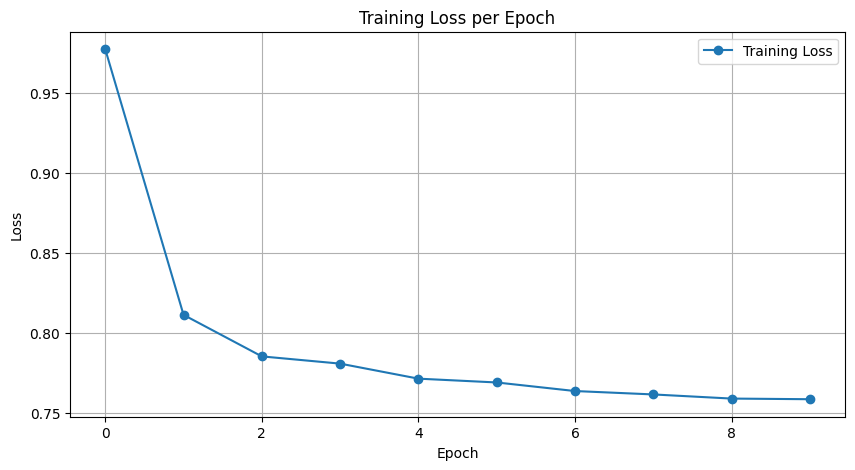

In [10]:
import torch.nn.functional as F
import matplotlib.pyplot as plt

num_epochs = 10
train_losses = []  # List to store losses of each epoch

for epoch in range(num_epochs):
    resnet18.train()
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = resnet18(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_loss)

    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}')

# Plotting the loss curve
plt.figure(figsize=(10, 5))
plt.plot(train_losses, marker='o', label='Training Loss')
plt.title('Training Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


In [11]:
def evaluate(model, data_loader, device):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0
    with torch.no_grad():  # Disable gradient computations for evaluation
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    return accuracy


### Evaluating the model

In [12]:
# Evaluating the model on MNIST test data
mnist_accuracy = evaluate(resnet18, mnist_test_loader, device)
print(f'Accuracy on MNIST Test Set: {mnist_accuracy:.2f}%')

# Evaluating the model on SVHN test data
svhn_accuracy = evaluate(resnet18, svhn_test_loader, device)
print(f'Accuracy on SVHN Test Set: {svhn_accuracy:.2f}%')


Accuracy on MNIST Test Set: 91.86%
Accuracy on SVHN Test Set: 11.89%


### FINE TUNE

In [16]:
from torch.utils.data import DataLoader, Subset

# Load SVHN dataset
svhn = datasets.SVHN(root='./data', split='train', download=True, transform=transform_train)

# Limit dataset to the first 1000 samples
subset_svhn = Subset(svhn, range(1000))

# Set up DataLoader
train_loader = DataLoader(svhn, batch_size=32, shuffle=True)

# Load pre-trained ResNet-18 model
resnet18 = models.resnet18(pretrained=True)

# Freeze convolutional layers
for param in resnet18.parameters():
    param.requires_grad = False

# Adjust final fully connected layer to match the number of classes in SVHN dataset (10)
num_classes = 10
resnet18.fc = nn.Linear(resnet18.fc.in_features, num_classes)

# Ensure classifier layer is unfrozen
for param in resnet18.fc.parameters():
    param.requires_grad = True


resnet18 = resnet18.to(device)

# Training settings
num_epochs = 10
train_losses = []

# Training loop
for epoch in range(num_epochs):
    resnet18.train()  # Set model to training mode
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = resnet18(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_loss)
    print(f"Epoch {epoch+1}, Loss: {epoch_loss:.4f}")


Using downloaded and verified file: ./data/train_32x32.mat


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1, Loss: 2.5409
Epoch 2, Loss: 2.5405
Epoch 3, Loss: 2.5419
Epoch 4, Loss: 2.5398
Epoch 5, Loss: 2.5425
Epoch 6, Loss: 2.5400
Epoch 7, Loss: 2.5400
Epoch 8, Loss: 2.5399
Epoch 9, Loss: 2.5403
Epoch 10, Loss: 2.5401


### Evaluation model

In [17]:
def evaluate(model, data_loader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():  # Disable gradient computations
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    return accuracy


In [19]:
# Evaluating the model on MNIST test data
mnist_accuracy = evaluate(resnet18, mnist_test_loader, device)
print(f'Accuracy on MNIST Test Set: {mnist_accuracy:.2f}%')

# Evaluating the model on SVHN test data
svhn_accuracy = evaluate(resnet18, svhn_test_loader, device)
print(f'Accuracy on SVHN Test Set: {svhn_accuracy:.2f}%')


Accuracy on MNIST Test Set: 69.09%
Accuracy on SVHN Test Set: 28.42%
